# Imports

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


# Data Preprocessing

In [30]:
DATA = './data'
drug_file = 'drug_data.csv'
mutations_file = 'mutations.csv'

mutations = pd.read_csv(os.path.join(DATA, mutations_file))
drug_data = pd.read_csv(os.path.join(DATA, drug_file))

print("Number of unique cell lines:")
print("Drug data:", drug_data['sample'].nunique())
print("Mutations:", mutations['Tumor_Sample_Barcode'].nunique())

print("Common cell lines:", len(set(mutations['Tumor_Sample_Barcode']).intersection(drug_data['sample'])))

Number of unique cell lines:
Drug data: 1629
Mutations: 1471
Common cell lines: 1471


## Cleanup drug data

In [31]:
TARGETS = [
        'RAF265:RAF_IC50_(uM)', 
        'PD-0325901:MEK_IC50_(uM)'
       ]

GENES = [
        'EGFR', 'KRAS', 'TP53', 'BRCA1', 'BRCA2', 'ALK', 'PIK3CA',
        'MAPK1', 'PTEN', 'HRAS', 'NRAS', 'AKT1', 'CDK4', 'CDK6', 'MYC', 'RET',
        'FGFR1', 'FGFR2', 'BRAF', 'SMAD4', 'MLH1', 'MUTYH', 'TSC1', 'TSC2',
        'VHL', 'IDH1', 'IDH2', 'SPOP', 'ARID1A', 'ATM', 'AXIN1', 'FBXW7',
        'RAD51', 'RB1', 'ERBB2', 'RPS6KB1', 'STK11', 'NOTCH1', 'NF1', 'KMT2C',
        'KMT2D'
]

CAT_COLS = ['Histology', 'Hist_Subtype1', 'Site_Primary']

In [32]:
drug_data.columns = drug_data.columns.str.replace(' ', '_')
drug_data.dropna(subset=TARGETS, inplace=True)

print("Number of new unique cell lines:")
print("Drug data:", drug_data['sample'].nunique())

Number of new unique cell lines:
Drug data: 460


## Create target (Sensitive or not)

If IC50 is below mean, drug is considered sensitive

- 1 = Sensitive to RAF265
- 2 = Sensitive to PD-0325901
- 3 = Sensitive to both
- 0 = Not Sensitive

In [33]:
def create_sensitivity_targets(df, targets):

    # Create sensitivity columns based on mean values of the targets
    sensitivity_cols = []
    for target in targets:
        sensitivity_col = f"{target.split('_')[0]}_sensitive"
        df[sensitivity_col] = df[target] < df[target].mean()
        sensitivity_cols.append(sensitivity_col)
    
    # Function to determine sensitivity category dynamically
    def get_sensitivity(row):
        # If any sensitivity column is True, return 1, else return 0
        return 1 if any(row[col] for col in sensitivity_cols) else 0
    
    # Apply the sensitivity function
    df['Target'] = df.apply(get_sensitivity, axis=1)
    
    # Display count of each target category
    target_counts = Counter(df['Target'])
    
    return df, target_counts

drug_data, target_counts = create_sensitivity_targets(drug_data, TARGETS)
print("Target Counts:", target_counts)

Target Counts: Counter({1: 322, 0: 138})


## Extract top ocurring mutations

In [34]:
top_mutations = (
    mutations.query('isDeleterious')
    .drop_duplicates(['Tumor_Sample_Barcode', 'Hugo_Symbol', 'Protein_Change'])
    .groupby(['Hugo_Symbol', 'Protein_Change'])
    .size()
    .reset_index(name='Count')
    .sort_values(by='Count', ascending=False)
)

MUTATIONS = (
    top_mutations[top_mutations['Count'] > 5] #at least present in 3 cell lines
    .assign(Mutation=lambda x: x['Hugo_Symbol'] + '_' + x['Protein_Change'])
    ['Mutation']
    .to_list()
)
print(f"Number of mutations to process: {len(MUTATIONS)}", MUTATIONS)

filtered_mutations = (
    mutations.query('isDeleterious')[['Tumor_Sample_Barcode', 'Hugo_Symbol', 'Protein_Change']]
    .drop_duplicates()
    .assign(Mutation=lambda x: x['Hugo_Symbol'] + '_' + x['Protein_Change'])
    .query('Mutation in @MUTATIONS')
    .reset_index(drop=True)
)

print("Number of unique cell lines:")
print("Mutations data:", filtered_mutations['Tumor_Sample_Barcode'].nunique())

Number of mutations to process: 21 ['ATM_p.K1903fs', 'TP53_p.R213*', 'TP53_p.T125T', 'BRCA2_p.K1530fs', 'KMT2D_p.P2354fs', 'ARID1A_p.G1848fs', 'KMT2C_p.K724*', 'ARID1A_p.G1849fs', 'PTEN_p.L265fs', 'TP53_p.R342*', 'BRCA2_p.Q1782fs', 'STK11_p.G279fs', 'TSC2_p.F297fs', 'PTEN_p.E288fs', 'TP53_p.R306*', 'BRAF_p.P403fs', 'TP53_p.P153fs', 'MLH1_p.L155fs', 'PTEN_p.R233*', 'PTEN_p.R130*', 'NF1_p.T676fs']
Number of unique cell lines:
Mutations data: 184


In [35]:
# Creating the pivot matrix
mutation_matrix = pd.crosstab(
    filtered_mutations['Tumor_Sample_Barcode'],  # Rows as 'Tumor_Sample_Barcode'
    filtered_mutations['Mutation'],              # Columns as 'Mutation'
    dropna=False                                 # Keep all combinations
)

# Converting values to binary (since crosstab gives counts)
mutation_matrix = mutation_matrix.clip(upper=1)

# Display the mutation matrix
mutation_matrix.head()

Mutation,ARID1A_p.G1848fs,ARID1A_p.G1849fs,ATM_p.K1903fs,BRAF_p.P403fs,BRCA2_p.K1530fs,BRCA2_p.Q1782fs,KMT2C_p.K724*,KMT2D_p.P2354fs,MLH1_p.L155fs,NF1_p.T676fs,...,PTEN_p.L265fs,PTEN_p.R130*,PTEN_p.R233*,STK11_p.G279fs,TP53_p.P153fs,TP53_p.R213*,TP53_p.R306*,TP53_p.R342*,TP53_p.T125T,TSC2_p.F297fs
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
22RV1_PROSTATE,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2313287_STOMACH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
253JBV_URINARY_TRACT,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59M_OVARY,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
647V_URINARY_TRACT,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Final data

In [36]:
merged_data = drug_data.set_index('sample').merge(mutation_matrix, left_index=True, right_index=True, how='left')
merged_data['Total_mutations'] = merged_data[MUTATIONS].sum(axis=1)
MUTATIONS += ['Total_mutations']

print("Number of final cell lines:", merged_data.index.nunique())

FEATURES = (
            GENES + 
            MUTATIONS + 
            CAT_COLS
            )   
print("Number of features:", len(FEATURES))

Number of final cell lines: 460
Number of features: 66


# Predictive Modelling

In [37]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X = merged_data[FEATURES]
y = merged_data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

preprocessor = ColumnTransformer(
        transformers=[
            ('Gene_exprs_imputer', SimpleImputer(strategy='median'), GENES),
            ('Mutations_imputer', SimpleImputer(strategy='constant', fill_value=0), MUTATIONS),
            ('Cat_encoder', OrdinalEncoder(
                                            categories='auto', dtype=np.int16, 
                                            handle_unknown='use_encoded_value', 
                                            unknown_value=-2, encoded_missing_value=-1
                                        ), 
                                        CAT_COLS),
        ],
        remainder='passthrough'  # This keeps all other columns unchanged
    )


pipe = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("classifier", lgb.LGBMClassifier(objective='binary', random_state=23, verbosity=-1)),
    ]
)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Gene_exprs_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['EGFR', 'KRAS', 'TP53',
                                                   'BRCA1', 'BRCA2', 'ALK',
                                                   'PIK3CA', 'MAPK1', 'PTEN',
                                                   'HRAS', 'NRAS', 'AKT1',
                                                   'CDK4', 'CDK6', 'MYC', 'RET',
                                                   'FGFR1', 'FGFR2', 'BRAF',
                                                   'SMAD4', 'MLH1', 'MUTYH',
                                                   'TSC1', 'TSC2', 'VHL',
                                                   'IDH1', 'IDH2', 'SPOP',
                                                   'ARI...
                                                   'TP53_p.P153fs',
                                                   'MLH1_p.L155fs',
                                                   'PTEN_p.R233*',
                                                   'PTEN_p.R130*',
                                                   'NF1_p.T676fs',
                                                   'Total_mutations']),
                                                 ('Cat_encoder',
                                                  OrdinalEncoder(dtype=<class 'numpy.int16'>,
                                                                 encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-2),
                                                  ['Histology', 'Hist_Subtype1',
                                                   'Site_Primary'])])),
                ('classifier',
                 LGBMClassifier(objective='binary', random_state=23,
                                verbosity=-1))])

In [38]:
from sklearn.metrics import accuracy_score, classification_report

predictions = pipe.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, predictions))

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.62      0.46      0.53        28
           1       0.79      0.88      0.83        64

    accuracy                           0.75        92
   macro avg       0.70      0.67      0.68        92
weighted avg       0.74      0.75      0.74        92



In [39]:
importances = pipe.named_steps['classifier'].feature_importances_

print("MOST IMPORTANT FEATURES:")

pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=True).tail(5)

MOST IMPORTANT FEATURES:


,feature,importance
5,ALK,49
39,KMT2C,55
64,Hist_Subtype1,69
8,PTEN,69
65,Site_Primary,105


In [40]:
# Write metrics to file
with open("./results/metrics.txt", "w") as outfile:
    outfile.write(f"\n{classification_report(y_test, predictions)}.")

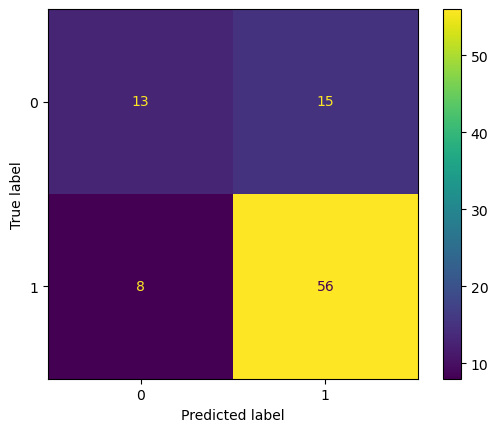

In [41]:
predictions = pipe.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.savefig("./results/model_results.png", dpi=120)

In [42]:
import skops.io as sio

sio.dump(pipe, "model/drug_pipeline.skops")